# Mott transition on the Bethe lattice Hubbard model

In this notebook you will reproduce the Bethe lattice DMFT that we did earlier with IPT,
but you will use the CT-INT solver to find the solution of the impurity problem. We will
consider the problem at half-filling again. You will see that the numerically
exact result is a bit different from IPT. This can be seen in the 
plot below that shows the Mott transition obtained by the iterated perturbation
theory and by the numerical renormalzation group. It is taken from
the article
_Finite-temperature numerical renormalization group study of the Mott transition_,
R. Bulla, T. A. Costi, and D. Vollhardt
Phys. Rev. B 64, 045103 (2001). Note that here the unit are $W = 4t$, where $W$ is the full bandwith of the
semicircular.

<img src="figures/dmft_bethe.png" alt="2d_hubbard" style="width: 400px;"/>


## Exercise 1

Write a DMFT loop, like you did earlier but this time using the CT-INT solver. Solve the Bethe lattice
model at $\beta=10$ for $U=4.0$ and $U=5.0$. Try to save your results to an archive in order to
postprocess them later.

*Hint*: It is useful to symmetrize the Green's function (make the `up` and `down` components the same) to avoid some artificial polarization of the system close to the Mott transition. You might want to enforce the `up`-`down` symmetry on `S.G` just before the self-consistency condition. In order
to have reasonable data you should have at least 10000 cycles. You will see that simulations take some time.

In [3]:
from triqs.gf import *
from triqs.operators import *
from h5 import *
import triqs.utility.mpi as mpi
from triqs_ctint import Solver
import numpy as np

# Parameters of the model
t = 1.0
beta = 10.0
n_loops = 10
n_iw = 400
delta = 0.1
n_cycles = 5000

# Construct the impurity solver
S = Solver(beta, n_iw)

# I run for several values of U
for U in [4.0, 5.0]:
    print('\n U =', U, '\n')

    # This is a first guess for G
    S.G_iw << SemiCircular(2*t)

    # DMFT loop with self-consistency
    for i in range(n_loops):
    
        print("Iteration = %i / %i" % (i+1, n_loops))
    
        # Symmetrize the Green's function and use self-consistency
        g = 0.5 * ( S.G_iw['up'] + S.G_iw['down'] )
        for name, g0 in S.G0_iw:
            g0 << inverse( iOmega_n + U/2.0 - t**2 * g )

        # Solve the impurity problem
        S.solve(U, delta, n_cycles)
    
        # Save iteration in archive
        with HDFArchive("results_U%.2f.h5"%U) as A:
            A['G0-%i'%i] = S.G0_iw
            A['G-%i'%i] = S.G_iw


 U = 4.0 

Iteration = 1 / 10
Iteration = 2 / 10
Iteration = 3 / 10
Iteration = 4 / 10
Iteration = 5 / 10
Iteration = 6 / 10
Iteration = 7 / 10
Iteration = 8 / 10
Iteration = 9 / 10
Iteration = 10 / 10

 U = 5.0 

Iteration = 1 / 10
Iteration = 2 / 10
Iteration = 3 / 10
Iteration = 4 / 10
Iteration = 5 / 10
Iteration = 6 / 10
Iteration = 7 / 10
Iteration = 8 / 10
Iteration = 9 / 10
Iteration = 10 / 10


Exercise 2
----------

Here, you will learn to analyze the output of the solver. As discussed, the Monte Carlo algorithm provide results on the
Matsubara axis. This makes the analysis of the results slightly more delicate than if we had them directly on the real
axis. When we used the IPT solver, we could see the Mott transition as the appearance of a gap in the spectral function.
After the Monte Carlo run, we do not have the spectral function, so we will have to use some other criteria to decide, e.g.,
if the system is metallic or insulating.

Plot the Green's function at the end of the DMFT loops for different values of $U$ (say 4 and 5). Focus on the extrapolation of the imaginary part of the Green's function to zero frequency. How does it change with $U$? Is there
a way to see the Mott transition just by inspecting the imaginary part of the Green's function?

Text(0, 0.5, '$G(i\\omega_n)$')

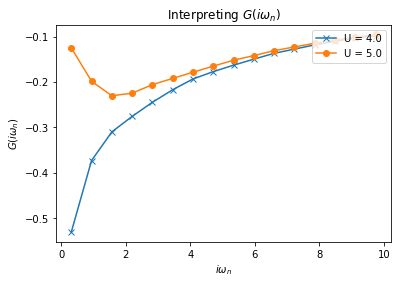

In [6]:
%matplotlib inline
from triqs.plot.mpl_interface import *

A1 = HDFArchive("results_U4.00.h5", 'r')
A2 = HDFArchive("results_U5.00.h5", 'r')

# Plot the Green's function of the last iteration
oploti(A1['G-9']['up'], '-x', x_window=(0,10), label='U = 4.0')
oploti(A2['G-9']['down'], '-o', x_window=(0,10), label='U = 5.0')

plt.title("Interpreting $G(i\omega_n)$")
plt.xlabel("$i\omega_n$")
plt.ylabel("$G(i\omega_n)$")

### Interpretation

As you can see, the behavior of the imaginary part is very different for the two values of $U$. When
$U$ is small, the system is a metal and the imaginary part extrapolated to zero goes to a finite value.
Instead, for large $U$, the system is a Mott insulator and the imaginary part goes to zero. The reason
is that the extrapolation to zero is directly proportional to the density of states at the chemical
potential. If the system is gapped, the density is zero; if the system is a metal, there is spectral
weight and the density is finite. Therefore, even on the Matsubara axis, one has a way to decide if the
system is metallic or not.

## Exercise 3

Do the same exercise as above, but analyze the self-energy. The noise usually gets bigger for larger frequencies, so just focus on the first few Matsubara frequencies. There the noise should not be too important. Again, by looking at the extrapolation to zero frequency of the imaginary part of the self-energy, can you tell where the Mott transition happens?

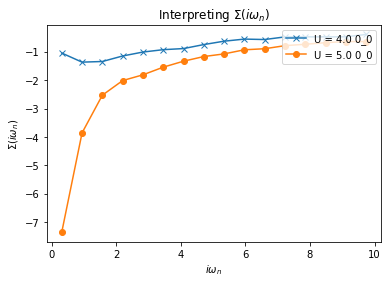

In [19]:
A1 = HDFArchive("results_U4.00.h5", 'r')
A2 = HDFArchive("results_U5.00.h5", 'r')

Sigma1 = inverse(A1['G0-9']) - inverse(A1['G-9'])
Sigma2 = inverse(A2['G0-9']) - inverse(A2['G-9'])

# Plot the self-energy of the last iteration
oplot(Sigma1['up'].imag, '-x', name='U = 4.0', x_window=(0,10))
oplot(Sigma2['up'].imag, '-o', name='U = 5.0', x_window=(0,10))

plt.title("Interpreting $\Sigma(i\omega_n)$")
plt.xlabel("$i\omega_n$")
plt.ylabel("$\Sigma(i\omega_n)$");

Here the extrapolation to zero goes to zero for the metal and diverges in the insulator. In general, we expect that the
self-energy goes to zero linearly at small frequencies in a Fermi-liquid metal. As we will see below, the slope
tells something about the degree of correlation. In the Mott insulator, a gap open because of the development of a
pole in the self-energy. The manifestation of this pole is a diverging imaginary part of the self-energy a low frequencies
as is visible here.

## Exercise 4

A very useful quantity to measure the degree of correlation of a metal is the *quasiparticle weight* $Z$. It is defined as

$$
Z = \lim_{\omega_n \rightarrow 0} \Big( 1 - \frac{d\mathrm{Im} \Sigma(i\omega_n)}{di\omega_n} \Big)^{-1}
$$

For a non-interacting metal $Z=1$. As correlations appear, $Z$ gradually gets smaller. It reaches 0 at the Mott transition. Compare $Z$ for the two values of $U$ that you computed above. If you have more time,
make a plot of $Z$ versus $U$ for the Bethe lattice Hubbard model.

*Hint*: In order to have access to the values of $\Sigma_\uparrow(i\omega_n)$, you can use `Sigma['up'](n)`. This will be useful to numerically compute the derivative required to compute $Z$.

### Solution

We estimate the derivative using the following approximation

$$
Z = \lim_{\omega_n \rightarrow 0} \Big( 1 - \frac{d\mathrm{Im} \Sigma(i\omega_n)}{di\omega_n} \Big)^{-1}
  \sim \Big( 1 - \frac{\mathrm{Im} \Sigma(i\omega_0)}{i\omega_0} \Big)^{-1}
$$

with $\omega_0 = \pi / \beta$ being the first Matsubara frequency.

Text(0, 0.5, 'Z')

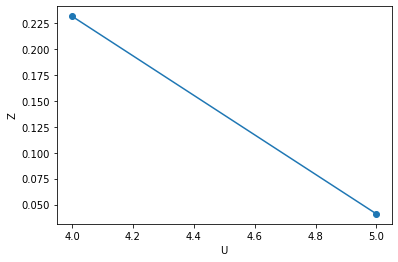

In [20]:
U_list = [4.0, 5.0]
Z_list = []

for U in U_list:
    
    A = HDFArchive("results_U%.2f.h5"%U, 'r')
    Sigma = inverse(A['G0-%i'%i]) - inverse(A['G-9'])
    
    Z = 1 / (1 - (Sigma['up'](0)[0,0].imag * beta / np.pi))
    Z_list.append(Z)
    
plt.plot(U_list, Z_list, '-o')
plt.xlabel('U')
plt.ylabel('Z')

Exercise 5
----------

Go back to your IPT code and try to modify it to extract the $Z$ versus $U$ curve. Compare this to the result you found in Exercise 4. Is the critical $U$ for the Mott transition similar to the one you found using CT-INT? Is
it compatible with the plot above?

1.0
0.7405705430914732
0.3175449864577424
0.017584057176008857
0.00765835533691361


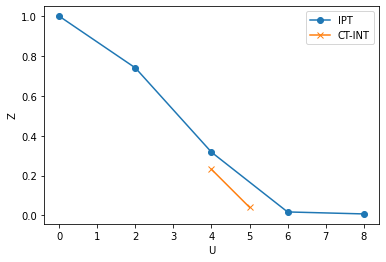

In [21]:
from triqs.gf import *
from triqs.plot.mpl_interface import *

class IPTSolver:

    def __init__(self, beta):

        self.beta = beta

        # Matsubara frequency
        self.g = GfImFreq(indices=[0], beta=beta, name='0')
        self.g0 = self.g.copy()
        self.sigma = self.g.copy()
        
        # Imaginary time
        self.g0t = GfImTime(indices=[0], beta = self.beta, name='G0t')
        self.sigmat = self.g0t.copy()
        
    def solve(self, U):

        self.g0t << Fourier(self.g0)
        self.sigmat << (U**2) * self.g0t * self.g0t * self.g0t
        self.sigma << Fourier(self.sigmat)

        # Dyson
        self.g << self.g0 * inverse(1.0 - self.sigma * self.g0)
        

t = 1.0
beta = 10
n_loops = 30

S = IPTSolver(beta = beta)

U_list2 = []
Z_list2 = []

for U in np.arange(0.0, 10.0, 2.0):
    
    S.g << SemiCircular(2*t)
    for i in range(n_loops):

        S.g0 << inverse( iOmega_n - t**2 * S.g )
        S.solve(U = U)

    Z = 1 / (1 - (S.sigma(0)[0,0].imag * beta / np.pi))
    U_list2.append(U)
    Z_list2.append(Z)
    
    print(Z)
    
plt.plot(U_list2, Z_list2, '-o', label='IPT')
plt.plot(U_list, Z_list, '-x', label='CT-INT')
plt.xlabel('U')
plt.ylabel('Z')
plt.legend()

Exercise 6
----------

Try to analytically continue the Green's function on the real axis using the Pade approximation. What can
you say about the result?

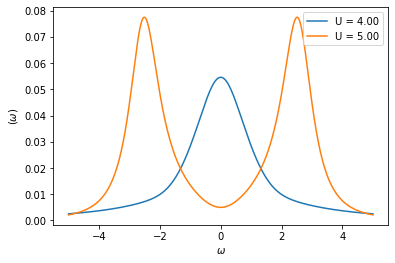

In [25]:
for U in [4.0, 5.0]:
    with HDFArchive("results_U%.2f.h5"%U, 'r') as A:
        for i in range(5,10):
            if i == 5:
                g = A['G-%i'%i]['up']
            else:
                g += A['G-%i'%i]['up']
            g /= 5
        # impose real part = 0
        g.data[:] = 0.5 * ( g.data - g.data.conjugate() )

    g_real = GfReFreq(indices=[0], window=[-5,5])
    g_real.set_from_pade(g)
    oplot(-g_real.imag/np.pi, label="U = %.2f"%U)

The result is very sensitive to the numerical noise. Things get better is in this half-filled case, we enfore that the real part is zero. One would have to make much longer runs in order to reduce the error bars and get
more stable analytical continuations. The Padé approximants can be used only on very accurate data. When the noise is still quite large, one has to use different analytical continuation methods, like MaxEnt.